# CLASSIFICATION PROJECT 
- Jakub Gazda 419 272
- Aleksander Wielniński 420 272

In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

## DATASET PREPERATION AND CLEANING

### Description and basic statistics

In [2]:
dataset = pd.read_csv("client_attrition_train.csv")

pd.options.display.float_format = '{:20.2f}'.format
dataset.head(n=5)

,customer_id,customer_age,customer_sex,customer_number_of_dependents,customer_education,customer_civil_status,customer_salary_range,customer_relationship_length,customer_available_credit_limit,credit_card_classification,...,period_inactive,contacts_in_last_year,credit_card_debt_balance,remaining_credit_limit,transaction_amount_ratio,total_transaction_amount,total_transaction_count,transaction_count_ratio,average_utilization,account_status
0,755410,38.00,F,2,High School,Married,40-60K,31,1593.00,Blue,...,2,4,1091,502.00,0.87,4136.00,67,0.72,0.69,open
1,568093,46.00,F,2,Graduate,Unknown,below 40K,40,6568.00,Blue,...,2,2,0,6568.00,0.10,1507.00,33,0.22,0.00,closed
2,595389,43.00,M,1,High School,Married,80-120K,30,34516.00,Silver,...,1,3,2045,32471.00,0.59,4081.00,54,0.42,0.06,open
3,287252,46.00,F,4,High School,Married,below 40K,36,2374.00,Blue,...,2,1,1332,1042.00,0.69,4253.00,81,0.88,0.56,open
4,231901,40.00,M,4,High School,Single,80-120K,29,12978.00,Blue,...,3,2,0,12978.00,0.63,14134.00,85,0.70,0.00,open


As displayed above the dataset includes 10127 observations in the training sample and 5063 in the test sample and the following columns:

* customer_id – unique observation identifier
* customer_age – age of the customer in years
* customer_sex – gender of the customer
* customer_number_of_dependents – number of dependents on the customer
* customer_education – education level of the customer
* customer_civil_status – civil status of the customer
* customer_salary_range – range of the annual salary of the customer
* customer_relationship_length – length of customer’s relationship with bank in months
* customer_available_credit_limit – available limit on the customer’s credit card account
* credit_card_classification – classification of the card (Blue, Silver, Gold, Platinum)
* total_products – total number of products held by the customer in the bank
* period_inactive – period in the last year when customer was inactive (in months)
* contacts_in_last_year – number of contacts with the customer in the last year
* credit_card_debt_balance – total card debt balance on the credit card account
* remaining_credit_limit – remaining limit on the customer’s credit card account (average in last year)
* transaction_amount_ratio – ratio in total amount of transactions in the 4th quarter against the 1st quarter
* total_transaction_amount – total amount of transactions in the last year
* total_transaction_count – total number of transactions in the last year
* transaction_count_ratio – ratio in total count of transactions in the 4th quarter against the 1st quarter
* average_utilization – average card utilization (percentage used of total limit)
* account_status – customer account status: closed, open (outcome variable, only in the training sample

In [3]:
x =dataset.describe(include=[np.number], percentiles=[.5]) \
    .transpose().drop("count", axis=1)

print(x)

                                                mean                  std  \
customer_id                                550508.99            261237.66   
customer_age                                   46.32                 8.00   
customer_number_of_dependents                   2.35                 1.30   
customer_relationship_length                   35.93                 7.99   
customer_available_credit_limit             10036.34             17629.71   
total_products                                  4.15                 3.18   
period_inactive                                 2.34                 1.01   
contacts_in_last_year                           2.46                 1.11   
credit_card_debt_balance                     1162.81               814.99   
remaining_credit_limit                       7469.14              9090.69   
transaction_amount_ratio                        0.76                 0.22   
total_transaction_amount                     5253.71              7402.26   

Above we can see the basic statistics of the numerical variables, with their means, standard deviations and maximum and minimum values. There we can find some concerning cases such as "customer_available_credit_limit", "remaining_credit_limit" or "total_transaction_amount" which standard deviations are larger than means, suggesting the occurance of large outliers, what is supported by the maximum values. We can of course notice already one variable that should be deleted from the model, that being "customer_id".

In [4]:
dataset.describe(include=[object]).transpose() \
    .drop("count", axis=1)

,unique,top,freq
customer_sex,2,F,4838
customer_education,7,Graduate,3128
customer_civil_status,4,Married,4687
customer_salary_range,6,below 40K,3327
credit_card_classification,4,Blue,9436
account_status,2,open,8500


When investing categorical variables we can see that there are few non-binary ones that will require further engineering, but as for right now we can see given the size of the database that there could be some imbalance problems with those variables, especially the dependant variable "account_status" which majority of values are "open".

### Missing values

In [5]:
# Getting the number of missing values in each column
num_missing = dataset.isna().sum()
# Excluding columns that contains 0 missing values
num_missing = num_missing[num_missing > 0]
# Getting the percentages of missing values
percent_missing = num_missing * 100 / dataset.shape[0]
# Concatenating the number and perecentage of missing values 
# into one dataframe and sorting it
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)

,Missing Values,Percentage
customer_sex,1018,10.05
customer_salary_range,681,6.72
customer_age,624,6.16
total_transaction_amount,407,4.02


Further data preperation involves clearing the missing values by deleting them, replacing or simply ignoring if they are relatively low in frequency. In our case however, each variable containing missing value has been dealt with in a similar way as displayed below.  

In [6]:
dataset["customer_sex"].fillna("Unknown", inplace=True)
dataset["customer_salary_range"].fillna("below 40K", inplace=True)
dataset["customer_age"].fillna(dataset["customer_age"].mean(), inplace=True)

It was decided to change the missing values of one categorical varible - "customer_sex" - by replacing the missing values with a new "Uknown" value. The Nans in varaible "customer_salay_range" were replaced with the most frequently occuring values (mode), and in the case of "customer_age" with the mean, as there was no telling of how to fill the missing values by looking at other variables. As an example an attempt is shown below.

In [7]:
x = dataset[["total_transaction_amount","total_transaction_count"]][dataset["total_transaction_amount"].isna()]
print(x)

       total_transaction_amount  total_transaction_count
6                           NaN                       63
103                         NaN                       27
107                         NaN                       81
116                         NaN                      121
146                         NaN                       35
...                         ...                      ...
9958                        NaN                       63
9979                        NaN                       32
10031                       NaN                       38
10081                       NaN                       78
10107                       NaN                      114

[407 rows x 2 columns]


I tried to investigate whether the missing values in "total_transaction_amount" are related to "total_transaction_count". The logic was pretty simple as there was a suspicion that NaNs are in fact zeros for cases when "total_transaction_count" is nonexistient, however that was not the case and the missing values ultimately were replaced with the mean of "total_transaction_amount".  

In [8]:
dataset["total_transaction_amount"].fillna(dataset["total_transaction_amount"].mean(), inplace=True)

In [9]:
dataset.isna().values.sum()
dataset = dataset.drop(columns=["customer_id","remaining_credit_limit"])

Just to check whether we dealt with missing values we print the sum of "Nas" in the dataset, and as we can see there are none. And while we are at it we also drop the useless "customer_id" column from the dataset and "remaining_credit_limit" variable to avoid multicorriarity issuses later in the model, as along with the "credit_card_debt_balance" it summed to "customer_available_credit_limit".

### Data visualization and further preperation

array([[<Axes: title={'center': 'customer_age'}>,
        <Axes: title={'center': 'customer_number_of_dependents'}>,
        <Axes: title={'center': 'customer_relationship_length'}>,
        <Axes: title={'center': 'customer_available_credit_limit'}>],
       [<Axes: title={'center': 'total_products'}>,
        <Axes: title={'center': 'period_inactive'}>,
        <Axes: title={'center': 'contacts_in_last_year'}>,
        <Axes: title={'center': 'credit_card_debt_balance'}>],
       [<Axes: title={'center': 'transaction_amount_ratio'}>,
        <Axes: title={'center': 'total_transaction_amount'}>,
        <Axes: title={'center': 'total_transaction_count'}>,
        <Axes: title={'center': 'transaction_count_ratio'}>],
       [<Axes: title={'center': 'average_utilization'}>, <Axes: >,
        <Axes: >, <Axes: >]], dtype=object)

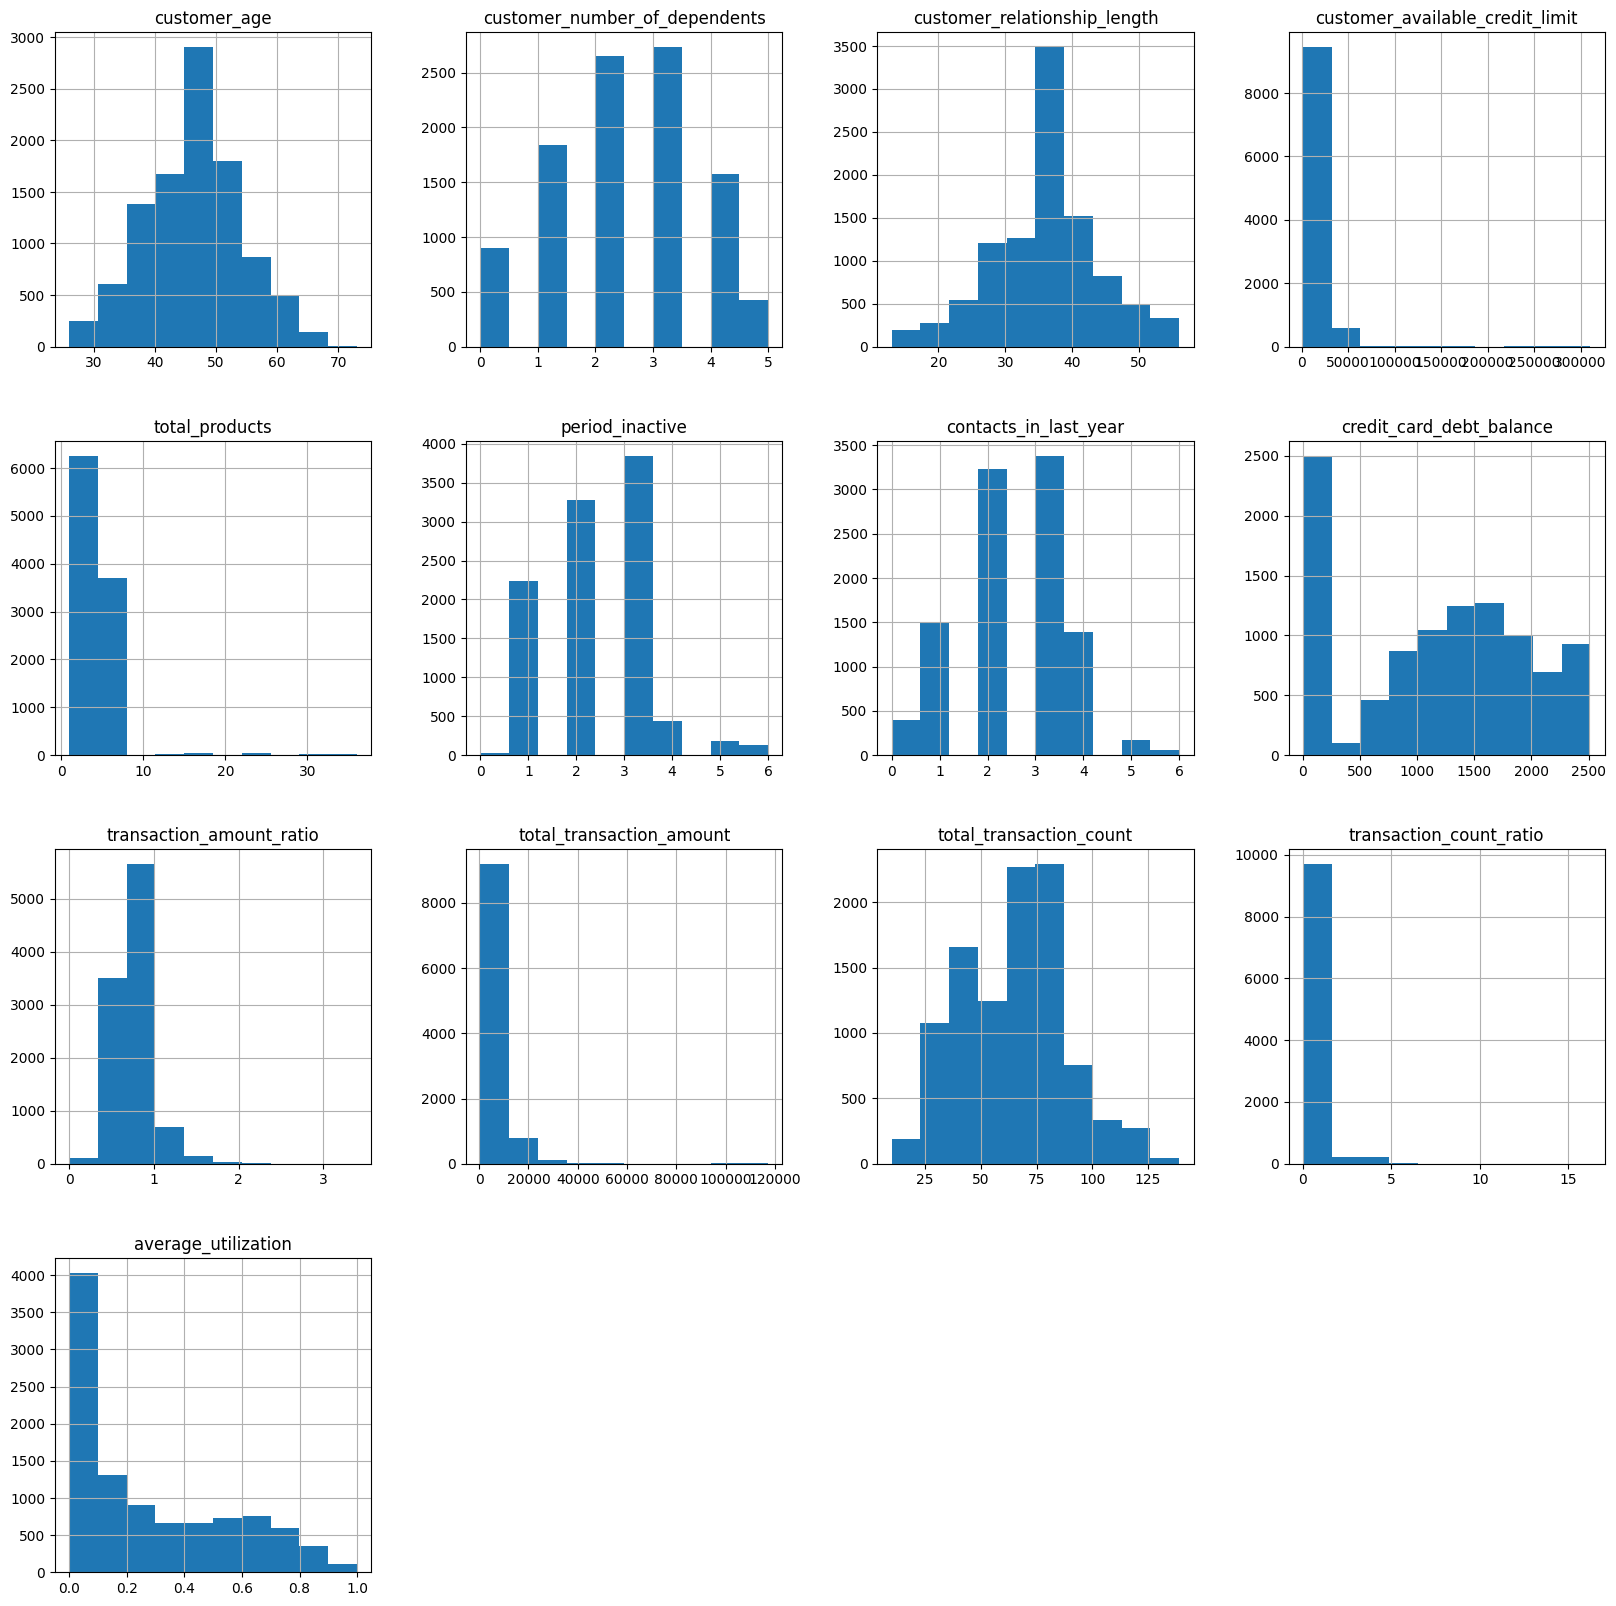

In [10]:
dataset.hist(figsize = (20,20))

As we can see from histogram displayed above, there are many numerical variables that are skewed to the left mainly due to outliers, such as "total_transaction_amount" or "customer_available_credit_limit", but there are also some that have by default a normal distribution, like "customer_age", "customer_relationship_length" or "total_transaction_count".

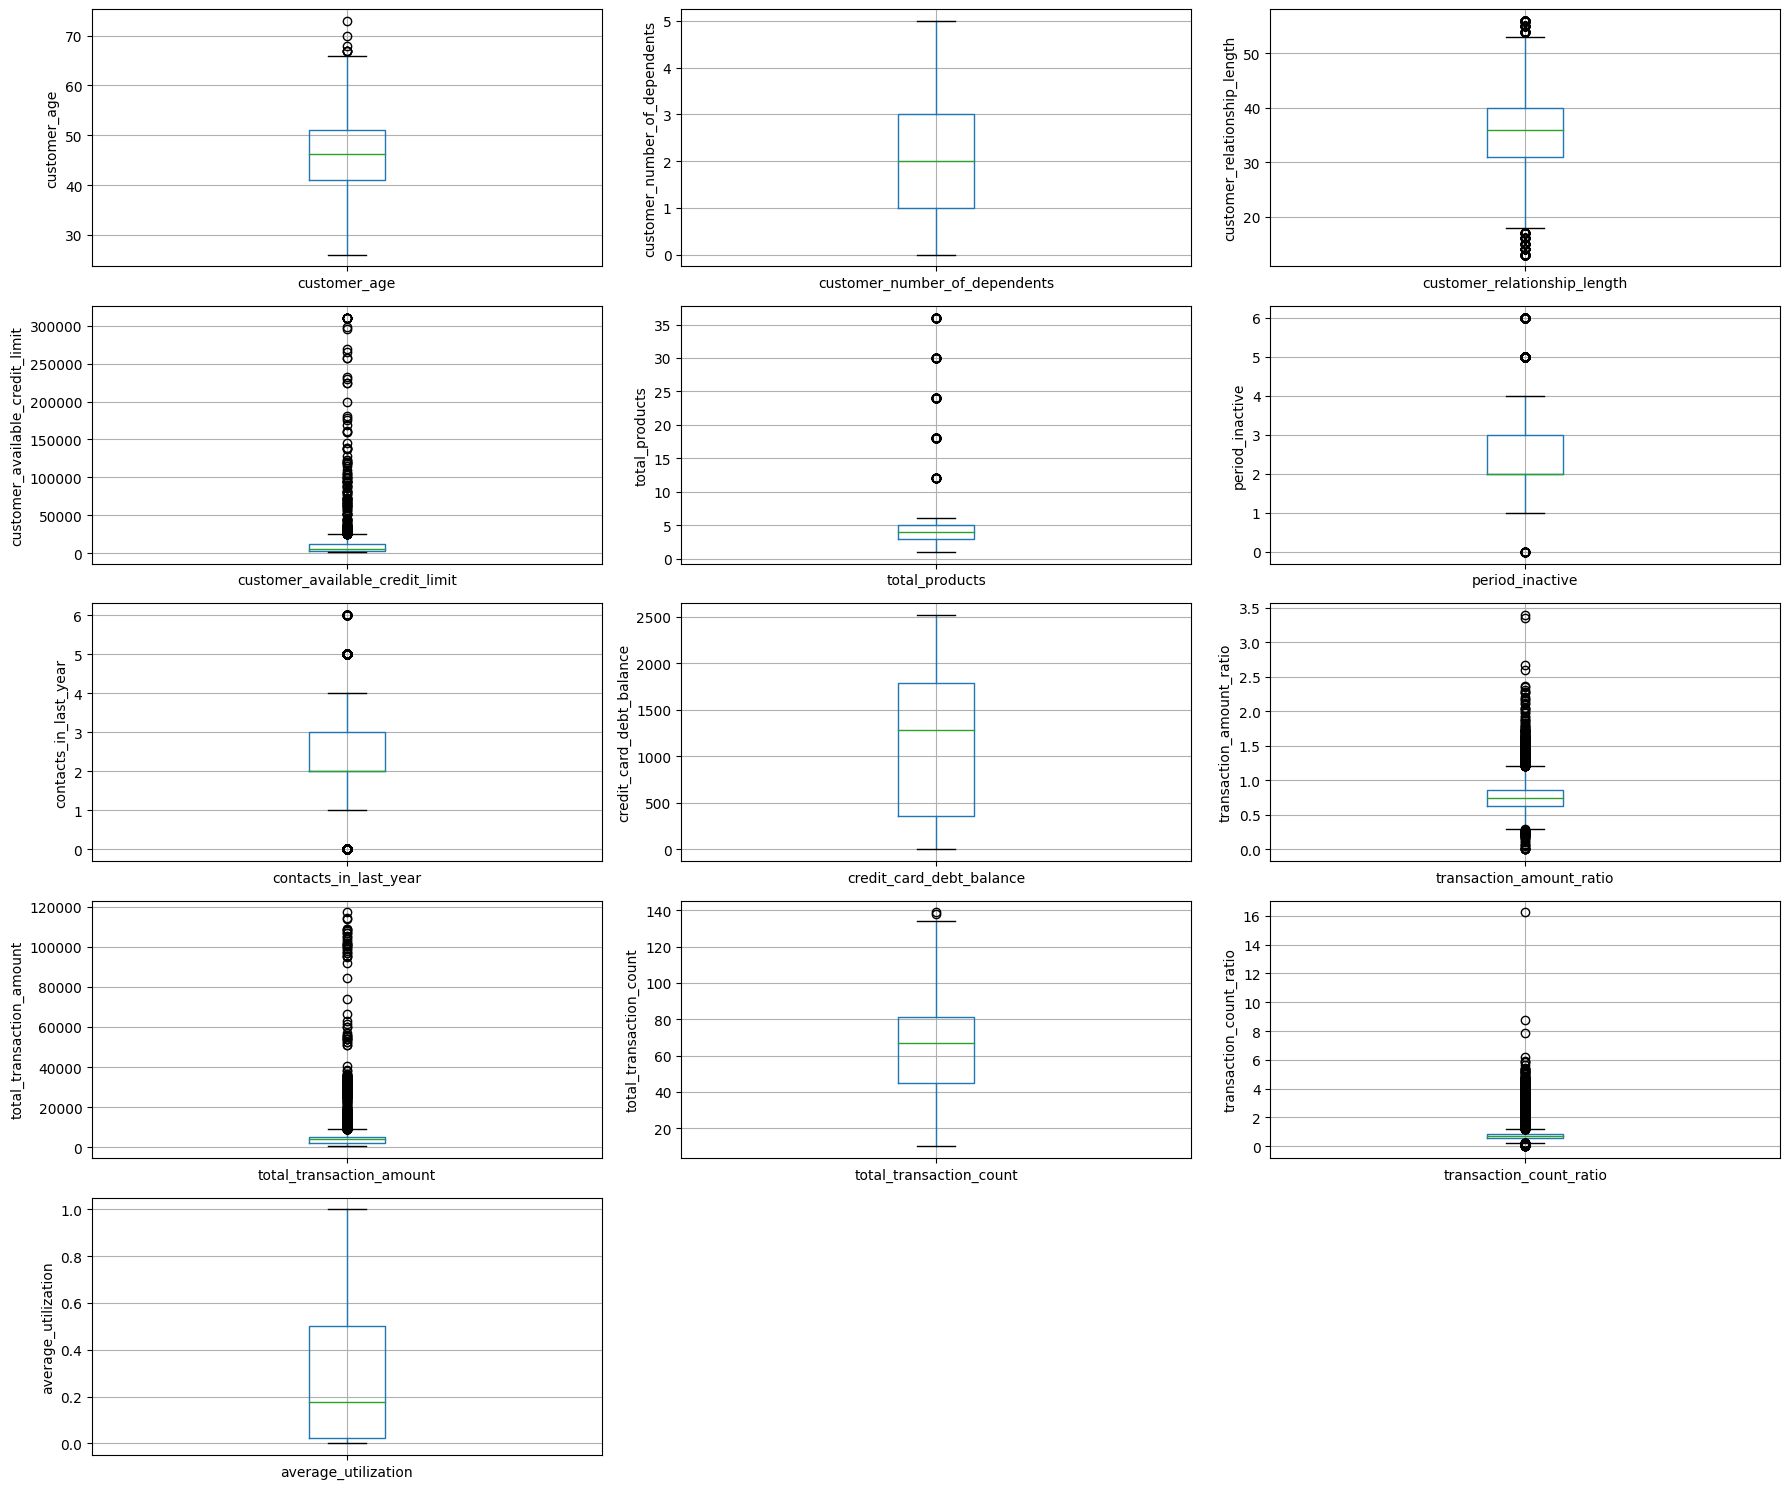

In [11]:
plt.figure(figsize=(18, 15))
num_vars = dataset.select_dtypes(include=[np.number]).columns  # Get numerical variable names
num_rows = (len(num_vars) -1 )// 3+1
for i, var in enumerate(num_vars):
    plt.subplot(num_rows, 3, i+1)
    dataset.boxplot(column=var)
    plt.title('')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

From the boxplots of our numerical variables we can see that there are many variables with larg amount of outliers creating high disproportions. Having considered potential options of dealing with these outliers, it was decided to remove the ones outstanding and creating skewed distributions for a bunch of variables. The idea was supported by the fact that dataset with outliers yielded worse results for majority fo models in terms of "balanced accuracy". Futhermore, an action to further decrease outliers influence and to fix the distributions was conducted by logarithming the variables. The effects are displayed below.

In [12]:
dataset = dataset[dataset["customer_age"] < 66]
dataset = dataset[(dataset["customer_age"] < 53) & (dataset["customer_age"] > 18)]
dataset = dataset[dataset["customer_available_credit_limit"] < 30000]
dataset = dataset[dataset["total_products"] < 10]
dataset = dataset[dataset["period_inactive"] < 5]
dataset = dataset[dataset["contacts_in_last_year"] < 5]
dataset = dataset[(dataset["transaction_amount_ratio"] < 1.5) & (dataset["transaction_amount_ratio"] > 0.25)]
dataset = dataset[dataset["total_transaction_amount"] < 20000]
dataset = dataset[dataset["total_transaction_count"] < 137]
dataset = dataset[dataset["transaction_count_ratio"] < 2]
dataset.reset_index(drop=True, inplace=True)

array([[<Axes: title={'center': 'log_customer_available_credit_limit'}>,
        <Axes: title={'center': 'log_total_transaction_amount'}>],
       [<Axes: title={'center': 'log_total_products'}>,
        <Axes: title={'center': 'log_average_utilization'}>],
       [<Axes: title={'center': 'log_transaction_amount_ratio'}>,
        <Axes: title={'center': 'log_transaction_count_ratio'}>]],
      dtype=object)

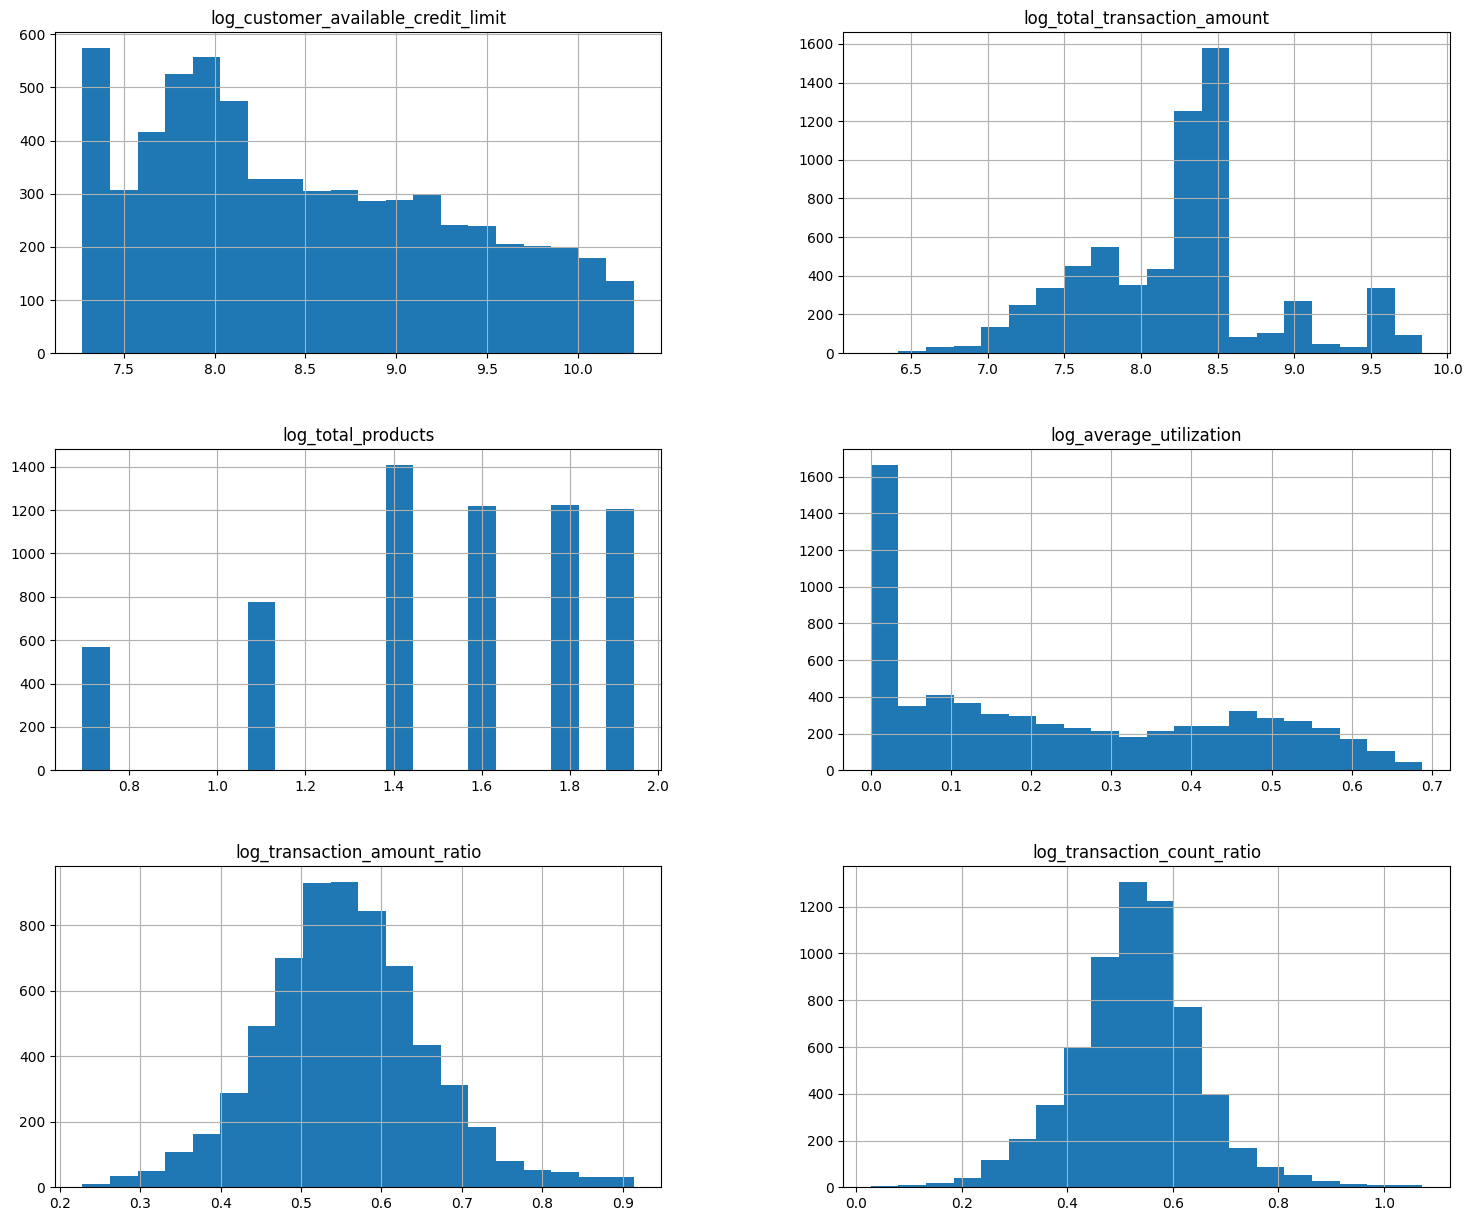

In [13]:
dataset["log_customer_available_credit_limit"] = np.log1p(dataset.customer_available_credit_limit)
dataset["log_total_transaction_amount"] = np.log1p(dataset.total_transaction_amount)
dataset["log_total_products"] = np.log1p(dataset.total_products)
dataset["log_average_utilization"] = np.log1p(dataset.average_utilization)
dataset["log_transaction_amount_ratio"] = np.log1p(dataset.transaction_amount_ratio)
dataset["log_transaction_count_ratio"] = np.log1p(dataset.transaction_count_ratio)
names = ["customer_available_credit_limit","total_transaction_amount","total_products","average_utilization","transaction_amount_ratio","transaction_count_ratio"]

dataset = dataset.drop(columns=names)
dataset.iloc[:, -6:].hist(figsize=(18,15), bins=20)


As we can see logarithming didn't fix the variables' distribution much, but it did help with their skewness in some cases so it was decided to leave them as there were. The next step was to look closely at the categorical variables to understand their role in the model, including the dependant variavle "account_status". 

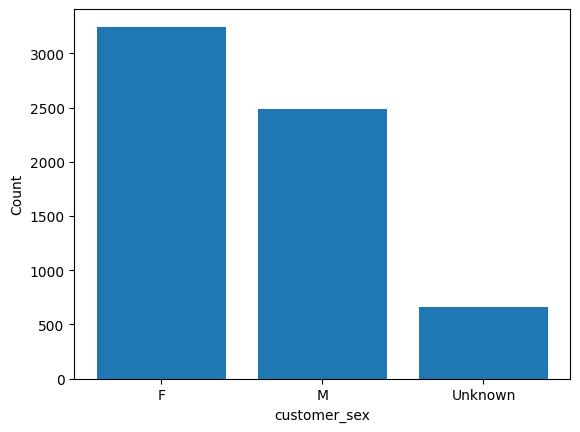

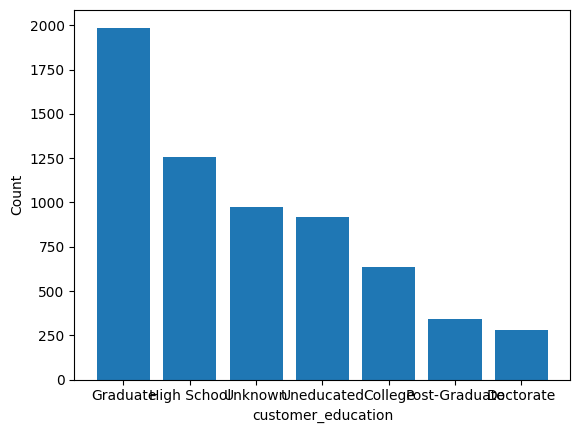

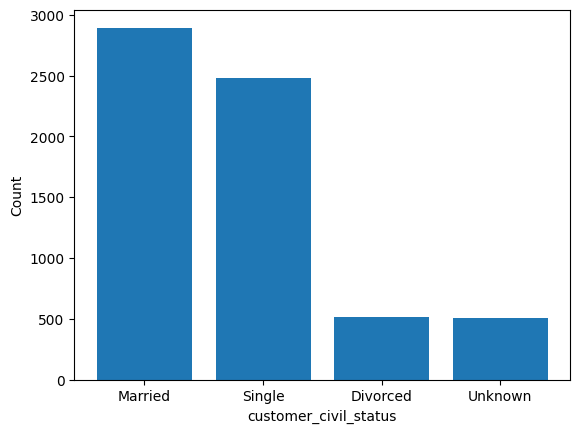

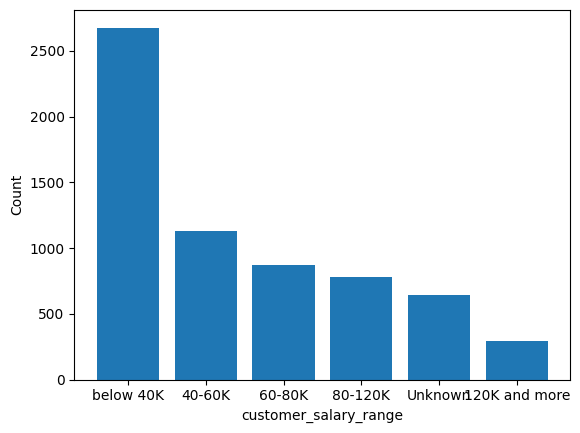

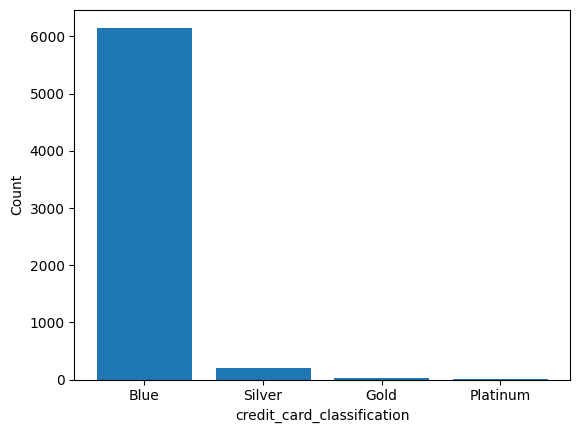

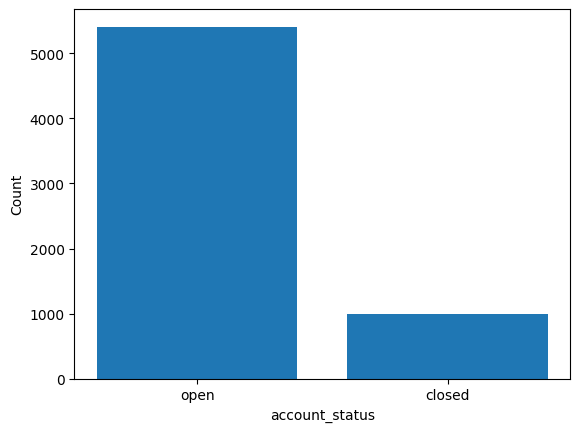

In [14]:
dataset_unique_values = dataset.select_dtypes(exclude=[np.number])
for column in dataset_unique_values:
    category_counts = dataset[column].value_counts()

    plt.bar(category_counts.index, category_counts.values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

Here we confirmed what we glanced at earlier, that being the imbalance of categorical variables, especially the dependant variable which will be an issue during the modeling requiring a special approach even to the spliting the dataset.

## FEATURE ENGINEERING AND BASIC EDA

In [15]:
customer_sex_dummies = pd.get_dummies(dataset['customer_sex'],prefix='customer_sex')
customer_education_dummies = pd.get_dummies(dataset['customer_education'],prefix='customer_education')
customer_civil_status_dummies = pd.get_dummies(dataset['customer_civil_status'],prefix='customer_civil_status')
customer_salary_range_dummies = pd.get_dummies(dataset['customer_salary_range'],prefix='customer_salary_range')
credit_card_classification_dummies = pd.get_dummies(dataset['credit_card_classification'],prefix='credit_card_classification')
account_status_dummies = pd.get_dummies(dataset['account_status'],prefix='account_status')

dataset = pd.concat([dataset, customer_sex_dummies, customer_education_dummies, customer_civil_status_dummies, customer_salary_range_dummies, credit_card_classification_dummies, account_status_dummies], axis=1)
dataset = dataset.drop(columns=['customer_sex','customer_education','customer_civil_status','customer_salary_range','credit_card_classification','account_status','customer_sex_Unknown','customer_education_Unknown','customer_civil_status_Unknown','customer_salary_range_Unknown','credit_card_classification_Blue','account_status_closed'], axis=1)

dataset.head()

,customer_age,customer_number_of_dependents,customer_relationship_length,period_inactive,contacts_in_last_year,credit_card_debt_balance,total_transaction_count,log_customer_available_credit_limit,log_total_transaction_amount,log_total_products,...,customer_civil_status_Single,customer_salary_range_120K and more,customer_salary_range_40-60K,customer_salary_range_60-80K,customer_salary_range_80-120K,customer_salary_range_below 40K,credit_card_classification_Gold,credit_card_classification_Platinum,credit_card_classification_Silver,account_status_open
0,38.00,2,31,2,4,1091,67,7.37,8.33,1.61,...,0,0,1,0,0,0,0,0,0,1
1,46.00,4,36,2,1,1332,81,7.77,8.36,1.79,...,0,0,0,0,0,1,0,0,0,1
2,40.00,4,29,3,2,0,85,9.47,9.56,1.39,...,1,0,0,0,1,0,0,0,0,1
3,51.00,4,42,1,2,2517,47,9.58,7.65,1.95,...,0,0,0,0,1,0,0,0,0,1
4,45.00,3,39,4,1,2253,63,7.84,8.57,1.79,...,1,0,0,0,0,1,0,0,0,1


As a first step we decided to change the categorical variables using One-hot encoding method. The process involved creating new binary columns for each unique category in the categorical variable. For each observation, only one of these binary columns will have a value of 1, indicating the presence of that category, while the rest will be 0. After that original columns were deleted along with one newly created dummy, as it reduced the size of the model keeping the full information. 

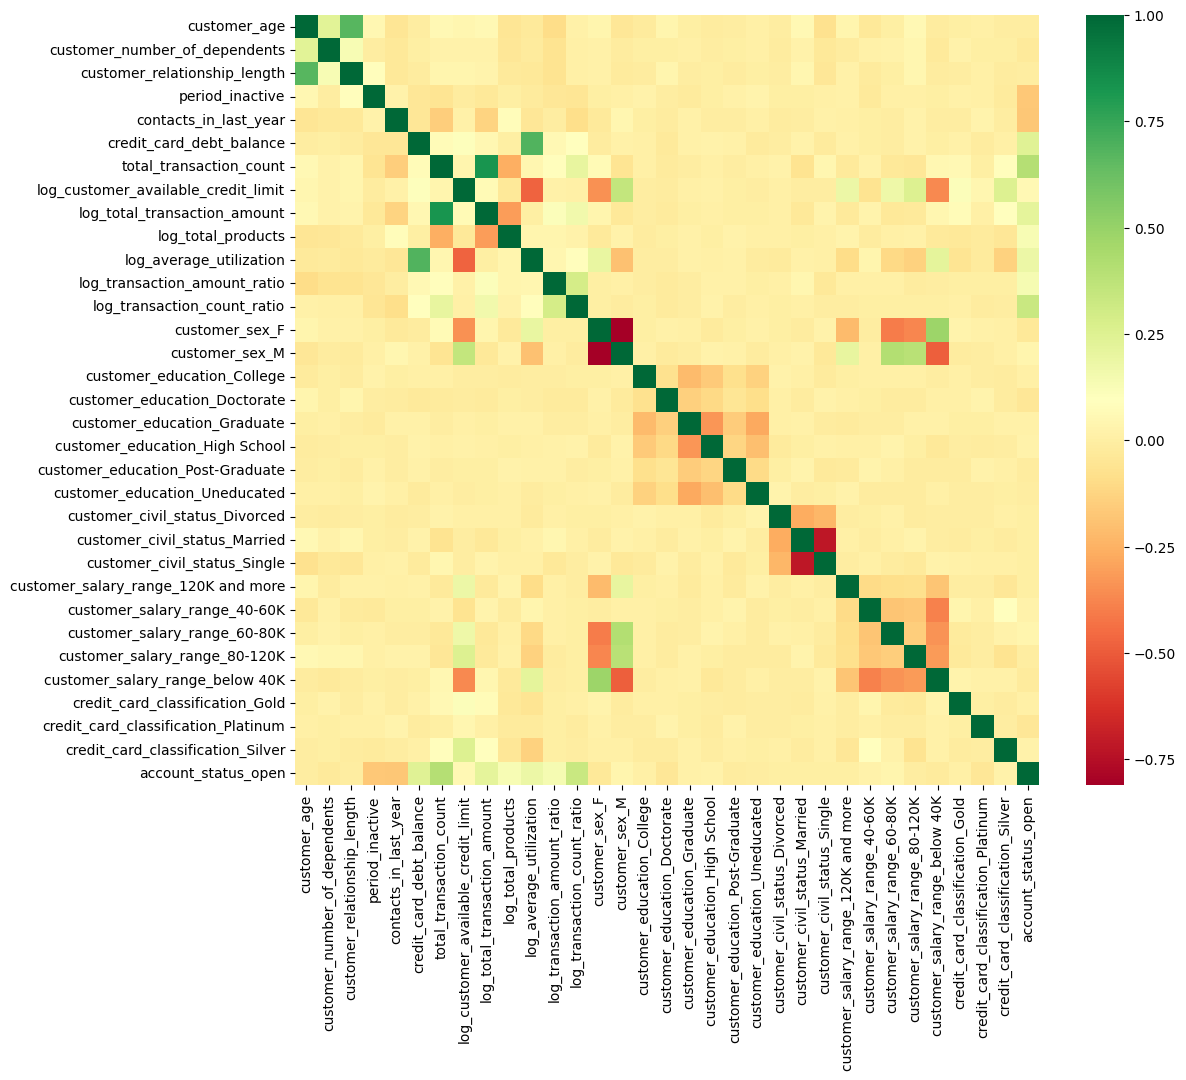

In [16]:
plt.figure(figsize=(12,10))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(dataset.corr(), annot=False,cmap ='RdYlGn')  # seaborn has very simple solution for heatmap

From the heatmap we can see all the variables in the model and their correlations with each other. Majority of them have no to little correlation fluctuating around 0, however there are some strong correlations, mainly in the dummy variables created for the categorical variables, such as "customer_sex" that had 3 categories, and with deleted "Unknown" remaining two are "F" and "M" which show strong correlation as "Unknown" only occupied 10% of the variable. What is interesting is that very little variables have any correlation with the dependant variable "account_status", beside "log_transaction_count", "credid_card_debt_balance" or "contacts_in_last_year".

In [17]:
scaler = StandardScaler()
# We need to fit the scaler to our data before transformation
dataset.loc[:, dataset.columns != 'account_status_open'] = scaler.fit_transform(
    dataset.loc[:, dataset.columns != 'account_status_open'])

It was also decided to use standarizaiton to improve the modeling, so every variable beside dependant variable were rescaled.

In [18]:
X = dataset.drop(['account_status_open'], axis=1)
y = dataset['account_status_open']
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=1/5,random_state=42, stratify=y)
X_train.describe().transpose().drop('count', axis=1)

,mean,std,min,25%,50%,75%,max
customer_age,0.00,1.00,-2.94,-0.57,0.28,0.79,1.47
customer_number_of_dependents,-0.01,1.00,-2.01,-0.41,0.38,0.38,1.98
customer_relationship_length,0.01,1.00,-3.02,-0.52,0.36,0.50,3.29
period_inactive,0.01,1.01,-2.62,-0.28,-0.28,0.88,2.05
contacts_in_last_year,0.00,1.00,-2.31,-0.37,-0.37,0.60,1.57
credit_card_debt_balance,-0.00,1.00,-1.40,-1.40,0.14,0.76,1.69
total_transaction_count,-0.00,1.00,-2.51,-0.86,0.12,0.66,2.90
log_customer_available_credit_limit,0.00,1.00,-1.46,-0.81,-0.19,0.78,2.17
log_total_transaction_amount,-0.01,1.00,-3.23,-0.71,0.15,0.43,2.60
log_total_products,-0.00,1.00,-2.23,-0.35,0.26,0.75,1.17


Having the data standardized, the dataset was split using using a stratify to divide the dataset into a training set (80%) and validaton set (20%) keeping the same proportion of dependant variable values in each split, as a way of dealing with imbalanced dataset. It is worth mentioning that the dependant variable was seperated from the main dataset. Above we can also see statistics of the new values after standarization. 

## MODELING

After finishing the data preperation it is time to create our models. The process of trying each model on the train dataset was exact the same so the detailed analysis will be found after the last model in the next chapter, but for now the method of finding the best performing model was conducted as follows:
1. We look for the best hyperparameters using GridSearch as a way to replace the need for tuning that calculates the score of each combination of parameters and outputs the parameters that combined created the highest score;
2. Then the model is trained on the training dataset wiht the set of the best parameters;
3. We generate predictions for the model for validation sample;
4. Generating a confusion matrix and basic metrics to glance at the performance;
5. Calculating our main performance statistic which is "balanced accuracy" which will be used to compare our models;

<b> HOWEVER, AS REQUESTED BY THE TEACHER THIS CODE PRESENT ONLY THE FINAL CODE WITHOUT COMPARING MODELS AND LOOKING FOR THEIR BEST PARAMETERS BUT THE WINNING MODEL WHICH IS XGBOOST (KNN, SVC, LOGISTIC REGRESSION AND RANDOM FOREST FELL OFF IN COMPARISON WITH XGBOOST) - MORE DETAILS ABOUT THE PROCCES OF CHOSING THE BEST MODEL ARE IN PRESENTATION!!!

### XGBoost

We tried another model using bunch of trees having the following hyperparameters tuned to generate the best predictions base of "balanced accuracy". The "colsample_bytree" parameter was set to 1.0, indicating that all features were considered for each tree in the boosting process. The "learning_rate" parameter was set to 0.1, which controls the step size shrinkage during each boosting iteration. The "max_depth" parameter was set to 4, specifying the maximum depth of each tree in the ensemble. This helps control the complexity and depth of the trees to avoid overfitting. The "n_estimators" parameter was set to 300, indicating the number of boosting rounds or the number of trees in the ensemble. The "subsample" parameter was set to 0.8, indicating the fraction of samples used for training each tree.

In [19]:
xb = xgb.XGBClassifier(colsample_bytree=1.0, learning_rate=0.1, max_depth= 4, n_estimators=300, subsample=0.8)
xb.fit(X_train,y_train)
y_pred_xb = xb.predict(X_val)

Text(0.5, 23.52222222222222, 'Predicted label')

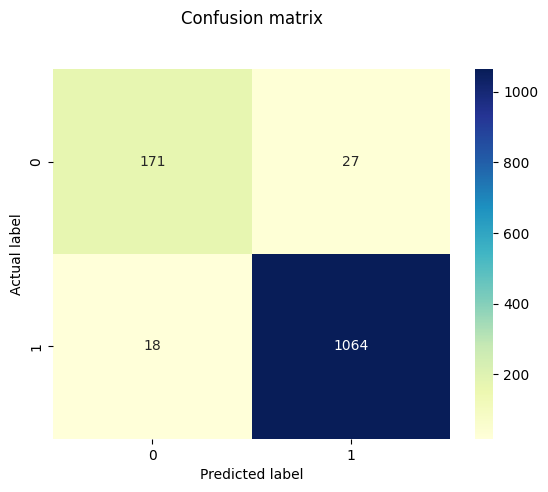

In [20]:
cnf_matrix = metrics.confusion_matrix(y_val, y_pred_xb)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [21]:
print(metrics.classification_report(y_val,y_pred_xb))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       198
           1       0.98      0.98      0.98      1082

    accuracy                           0.96      1280
   macro avg       0.94      0.92      0.93      1280
weighted avg       0.96      0.96      0.96      1280



In [22]:
tn, fp, fn, tp = cnf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
balanced_accuracy = (sensitivity + specificity) / 2
print("Balanced Accuracy:", balanced_accuracy)

Balanced Accuracy: 0.9235002520584776


XGBoost as we can see was trained and tuned in such way that it generated slightly better results than it's Random Forest. The "balanced accuracy" score is by far the best from all the different models that were trained on a trained sample and made predictions on validation sets. The model scores very good on both predictors them being "closed" and "open" accounts, what is supported by the basic metrics such as precision or recall.  

## PRINTING PREDICTIONS

In [23]:
df_test = pd.read_csv("client_attrition_test.csv")
df_test["customer_sex"].fillna("Unknown", inplace=True)
df_test["customer_salary_range"].fillna("below 40K", inplace=True)
df_test["customer_age"].fillna(df_test["customer_age"].mean(), inplace=True)
df_test["total_transaction_amount"].fillna(df_test["total_transaction_amount"].mean(), inplace=True)
df_test = df_test.drop(columns=["customer_id","remaining_credit_limit"])


df_test["log_customer_available_credit_limit"] = np.log1p(df_test.customer_available_credit_limit)
df_test["log_total_transaction_amount"] = np.log1p(df_test.total_transaction_amount)
df_test["log_total_products"] = np.log1p(df_test.total_products)
df_test["log_average_utilization"] = np.log1p(df_test.average_utilization)
df_test["log_transaction_amount_ratio"] = np.log1p(df_test.transaction_amount_ratio)
df_test["log_transaction_count_ratio"] = np.log1p(df_test.transaction_count_ratio)
names = ["customer_available_credit_limit","total_transaction_amount","total_products","average_utilization","transaction_amount_ratio","transaction_count_ratio"]
df_test = df_test.drop(columns=names)
customer_sex_dummies = pd.get_dummies(df_test['customer_sex'],prefix='customer_sex')
customer_education_dummies = pd.get_dummies(df_test['customer_education'],prefix='customer_education')
customer_civil_status_dummies = pd.get_dummies(df_test['customer_civil_status'],prefix='customer_civil_status')
customer_salary_range_dummies = pd.get_dummies(df_test['customer_salary_range'],prefix='customer_salary_range')
credit_card_classification_dummies = pd.get_dummies(df_test['credit_card_classification'],prefix='credit_card_classification')
df_test = pd.concat([df_test, customer_sex_dummies, customer_education_dummies, customer_civil_status_dummies, customer_salary_range_dummies, credit_card_classification_dummies], axis=1)
df_test = df_test.drop(columns=['customer_sex','customer_education','customer_civil_status','customer_salary_range','credit_card_classification','customer_sex_Unknown','customer_education_Unknown','customer_civil_status_Unknown','customer_salary_range_Unknown','credit_card_classification_Blue'], axis=1)
df_test['credit_card_classification_Platinum'] = 0
columns = df_test.columns.tolist()
columns[-1], columns[-2] = columns[-2], columns[-1]
df_test = df_test[columns]
df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)
predictions = xb.predict(df_test)
predictions

array([1, 1, 1, ..., 1, 1, 1])

The predictions are saved in the csv with the following rule - 1s are "account_status" being "open" and 0s are "closed".

In [24]:
predictions_df = pd.DataFrame(predictions, columns=['account_status_open_predictions'])
predictions_df.to_csv('predictions.csv', index=False)